In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [3]:
def on_kaggle() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [4]:
# HYPER PARAMETERS
ON_KAGGLE = on_kaggle()
SAMPLE_LEVEL = 1

USE_SAMPLE = SAMPLE_LEVEL == 1
USE_TOY_SAMPLE = SAMPLE_LEVEL == 2

FORCE_REWRITE = True#(ON_KAGGLE and SAMPLE_LEVEL == 0)

In [5]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')

In [6]:
#IMPORT_SCRIPT!
# THIS CELL WILL BE REMOVE WITH SCRIPTS IN SRC
if './src/' not in sys.path:
    sys.path.append('./src/')

from preprocessing import *
from metrics import *
from cv import *

In [7]:
if ON_KAGGLE:
    RAW_DIR = Path('../input/g-research-crypto-forecasting/')
    SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/sample/')
    TOY_SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/toy_sample/')
else:
    RAW_DIR =  Path('data/raw')
    TOY_SAMPLE_DIR = RAW_DIR.joinpath('toy_sample')
    SAMPLE_DIR = RAW_DIR.joinpath('sample')

# filename
TRAIN_FILE = 'train.csv'
ASSET_DETAILS_PATH = RAW_DIR / 'asset_details.csv'

In [8]:
if USE_TOY_SAMPLE:
    print('USING TOY DATASET')
    RAW_TRAIN_PATH = TOY_SAMPLE_DIR / TRAIN_FILE

elif USE_SAMPLE:
    print('USING SAMPLE DATASET')
    RAW_TRAIN_PATH = SAMPLE_DIR / TRAIN_FILE

else:
    print('USING RAW DATASET')
    RAW_TRAIN_PATH = RAW_DIR / TRAIN_FILE

assert RAW_TRAIN_PATH.exists()

USING SAMPLE DATASET


In [9]:
!ls {RAW_DIR}

asset_details.csv		   sample
example_sample_submission.csv	   supplemental_train.csv
example_test.csv		   toy_sample
g-research-crypto-forecasting.zip  train.csv
gresearch_crypto


In [10]:
%%time 
raw_df = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 4.23 s, sys: 463 ms, total: 4.69 s
Wall time: 5.21 s


In [11]:
raw_df = ingest_data(raw_df, asset_details_path=ASSET_DETAILS_PATH)

In [12]:
raw_df.sort_values(by=['Asset_ID', 'date'], inplace=True)
raw_df.reset_index(drop=True, inplace=True)

In [13]:
raw_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,date
0,1609459260,0,219.0,37.384998,37.422100,37.348701,37.389000,2749.5692,37.387058,-0.001669,Binance Coin,2021-01-01 00:01:00
1,1609459320,0,133.0,37.390499,37.402000,37.329800,37.331299,778.8680,37.351677,-0.001542,Binance Coin,2021-01-01 00:02:00
2,1609459380,0,151.0,37.317051,37.336700,37.272900,37.291500,890.9210,37.301258,-0.001028,Binance Coin,2021-01-01 00:03:00
3,1609459440,0,123.0,37.299149,37.323002,37.250198,37.291901,489.9361,37.297272,0.000174,Binance Coin,2021-01-01 00:04:00
4,1609459500,0,623.0,37.212799,37.285000,37.104801,37.213001,15144.3836,37.184082,0.000950,Binance Coin,2021-01-01 00:05:00


In [14]:
TARGET = 'Target'
INDEX_COLS = ['Asset_ID', 'Asset_Name', 'date', 'timestamp']

In [15]:
RAW_FEATURES = ['Count', 'Open', 'High', 'Low', 'Close',
       'Volume', 'VWAP']

In [16]:
for feature in RAW_FEATURES:
    fmin = raw_df.groupby('Asset_ID')[feature].min()
    fmax = raw_df.groupby('Asset_ID')[feature].max()
    
    broadcasted_fmin = raw_df['Asset_ID'].map(fmin)
    broadcasted_fmax = raw_df['Asset_ID'].map(fmax)
    
    raw_df[feature] = (raw_df[feature] - broadcasted_fmin) / (broadcasted_fmax - broadcasted_fmin)

In [17]:
feature_data = compute_features(raw_df)

In [18]:
feature_data = feature_data.dropna(subset=[TARGET]).reset_index(drop=True)

In [19]:
feature_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,date,upper_shadow,lower_shador
0,1609459260,0,0.006801,0.003490,0.003307,0.003532,0.003456,0.023120,0.003444,-0.001669,Binance Coin,2021-01-01 00:01:00,-0.000182,-0.000075
1,1609459320,0,0.004118,0.003498,0.003277,0.003503,0.003368,0.006549,0.003390,-0.001542,Binance Coin,2021-01-01 00:02:00,-0.000221,-0.000134
2,1609459380,0,0.004680,0.003386,0.003177,0.003416,0.003308,0.007491,0.003313,-0.001028,Binance Coin,2021-01-01 00:03:00,-0.000209,-0.000108
3,1609459440,0,0.003806,0.003359,0.003156,0.003381,0.003308,0.004120,0.003307,0.000174,Binance Coin,2021-01-01 00:04:00,-0.000202,-0.000073
4,1609459500,0,0.019406,0.003227,0.003099,0.003159,0.003188,0.127344,0.003134,0.000950,Binance Coin,2021-01-01 00:05:00,-0.000129,0.000029


In [20]:
feature_data.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,date,upper_shadow,lower_shador
5298791,1632181200,13,0.031926,0.420102,0.420396,0.429999,0.420512,0.016266,0.420315,0.000199,TRON,2021-09-20 23:40:00,-0.000116,-0.009896
5298792,1632181260,13,0.023142,0.420921,0.421849,0.431739,0.422220,0.005642,0.422231,-0.003477,TRON,2021-09-20 23:41:00,-0.000371,-0.010818
5298793,1632181320,13,0.017049,0.421967,0.421967,0.432461,0.422067,0.006768,0.422627,-0.002437,TRON,2021-09-20 23:42:00,-0.000100,-0.010494
5298794,1632181380,13,0.014974,0.422199,0.421934,0.432048,0.421423,0.004450,0.422273,0.004843,TRON,2021-09-20 23:43:00,-0.000265,-0.010625
5298795,1632181440,13,0.016562,0.420780,0.420911,0.430779,0.420149,0.005392,0.421044,0.004163,TRON,2021-09-20 23:44:00,0.000131,-0.010630


In [21]:
PULIC_LB_RANGE = ['2021-06-13 00:00:00',
                  '2021-09-13 00:00:00'] # 3 MONTH WORTH OF DATA

if USE_TOY_SAMPLE:
    EVAL_PERIODS = [['2021-09-15', '2021-09-22']]

elif USE_SAMPLE:
    EVAL_PERIODS = [PULIC_LB_RANGE]
    
else:
    EVAL_PERIODS = [['2019-01-01', '2019-04-01'],
                    ['2021-03-13', '2021-06-12 00:00:00'], 
                    PULIC_LB_RANGE]

In [22]:
COLUMNS_TO_DROP = [TARGET, 'Asset_Name', 'date', 'timestamp']
FEATURES = feature_data.columns.drop(COLUMNS_TO_DROP)
MODEL_PARAMS = {'n_estimators': 500,
 'max_depth': 11,
 'learning_rate': 0.05,
 'subsample': 0.9,
 'colsample_bytree': 0.7,
 'tree_method': 'hist',
 'missing': -999,
 'random_state': 2020}
OUTPUT_PATH = Path('artifacts/baseline/')
if SAMPLE_LEVEL > 0:
    OUTPUT_PATH = OUTPUT_PATH / f'sample/{SAMPLE_LEVEL}'
OUTPUT_PATH.mkdir(exist_ok=True, parents=True)
OUTPUT_MODEL_PATH = OUTPUT_PATH / 'xgb.pkl'

In [23]:
FEATURES

Index(['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'upper_shadow', 'lower_shador'],
      dtype='object')

In [24]:
### make transformer

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from typing import List, Union
from sklearn.pipeline import FeatureUnion, Pipeline
from functools import reduce
from sklearn.preprocessing import FunctionTransformer


def join_columns(columns):
    return list(map(lambda f: '__'.join(map(str, f)), columns))


def pandas_hstack(Xs):
    hstackX = np.concatenate(Xs, axis=1)
    columns = sum([list(X.columns) for X in Xs], [])
    return pd.DataFrame(hstackX, columns=columns)


def join_dataframes(A: pd.DataFrame, B: pd.DataFrame) -> pd.DataFrame:
    return pandas_hstack([A, B])

class PdColumnTransformer(ColumnTransformer):
    def _hstack(self, Xs):
        return reduce(join_dataframes, Xs)


class PdFeatureUnion(FeatureUnion):
    def _hstack(self, Xs):
        return reduce(join_dataframes, Xs)

In [26]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
# from sklearn.preprocessing import MinMaxScaler

In [27]:
def train_model(train_data: pd.DataFrame, valid_data: pd.DataFrame):
    model = XGBRegressor(**MODEL_PARAMS)
    model.fit(train_data[FEATURES], train_data[TARGET])
    
    yhat = model.predict(valid_data[FEATURES])
    return model, yhat

In [28]:
def filter_by_index(df: pd.DataFrame, index) -> pd.DataFrame:
    return df.loc[index, :].reset_index(drop=True)

In [29]:
CV = TimeSeriesSplit(EVAL_PERIODS, gap_unit='min')
SCORES = []
valid_corrs = pd.DataFrame()
for fold, (train_idx, valid_idx) in enumerate(CV.split(feature_data)):
    print(fold)
    train_data = filter_by_index(feature_data, train_idx)
    valid_data = filter_by_index(feature_data, valid_idx)
    
    model, yhat = train_model(train_data, valid_data)
    
    valid_data['yhat'] = yhat

    scores, fold_valid_corrs = compute_metrics(valid_data)
    scores['fold'] = fold
    valid_corrs = valid_corrs.append(fold_valid_corrs.assign(fold=fold), ignore_index=True)
    
    SCORES.append(scores)
    
cv_scores = pd.DataFrame(SCORES)

0


In [30]:
cv_scores

,weighted_corr,theor_corr,corr_min,corr_max,corr_std,fold
0,0.003278,0.008056,-0.061427,0.055753,0.025934,0.0


In [31]:
valid_corrs

,Asset_Name,corr,weight,weighted_corr,fold
0,Binance Coin,-0.001084,4.304065,-0.004667,0
1,Bitcoin,-0.000147,6.779922,-0.000997,0
2,Bitcoin Cash,-0.061427,2.397895,-0.147297,0
3,Cardano,0.018008,4.406719,0.079355,0
4,Dogecoin,0.021827,3.555348,0.077604,0
5,EOS.IO,0.007025,1.386294,0.009739,0
6,Ethereum,-0.006847,5.894403,-0.040360,0
7,Ethereum Classic,0.022420,2.079442,0.046621,0
8,IOTA,0.006241,1.098612,0.006857,0
9,Litecoin,0.007839,2.397895,0.018798,0


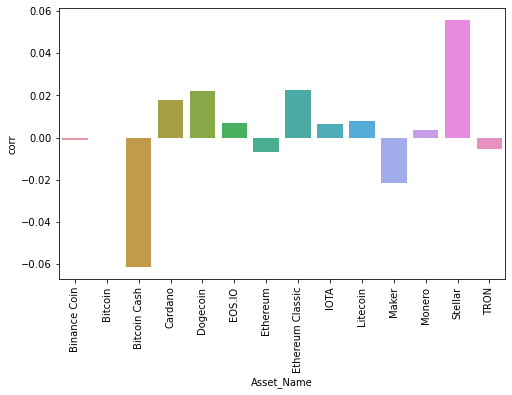

In [32]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Asset_Name', y='corr', data=valid_corrs)
plt.xticks(rotation=90);